In [ ]:
# install required system dependencies
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install x11-utils > /dev/null 2>&1
!pip install pyglet==v1.5.0

In [ ]:
import math
import time
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from collections import namedtuple
from itertools import count
from PIL import Image
import cv2

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# Open AI related
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only

import glob
import io
import base64
from IPython.display import HTML

# set up OpenAi Gym render in Colab
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
_display = Display(visible=False,  # use False with Xvfb
                   size=(1400, 900))
_ = _display.start()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Show Gym Environment

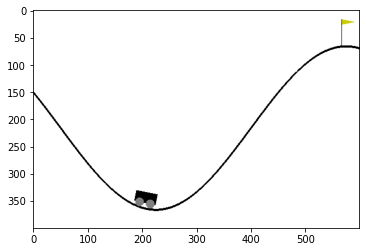

In [ ]:
env = gym.make('MountainCar-v0').unwrapped
env.reset()
env.state # (position, velocity)
img = plt.imshow(env.render(mode='rgb_array')) # returned screen by gym is 400x600x3

## Parameters

In [ ]:
BATCH_SIZE = 32
GAMMA = 0.999
EPS_START = 0.8 # explore rate (start)
EPS_END = 0.05 # explore rate (end)
MAX_EPS_DECAY_STEPS = 500000
TARGET_UPDATE = 10 # Freqency of updating target network, copying all weights and biases in DQN
REPLAY_MEMORY_SIZE = 50000
NUM_EPISODE = 150
HIDDEN_LAYER_DIM = 64

## Replay Memory

In [ ]:
Transition = namedtuple('Transition',('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

## Deep Q Network

In [ ]:
class DQN(nn.Module):
    def __init__(self, outputs):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(8, HIDDEN_LAYER_DIM )
        self.fc2 = nn.Linear(HIDDEN_LAYER_DIM , outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## Training

In [ ]:
# Get number of actions from gym action space
n_actions = env.action_space.n

policy_net = DQN(n_actions).to(device)
target_net = DQN(n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(REPLAY_MEMORY_SIZE)

steps_done = 0
episode_durations = []

In [ ]:
def stack_past_four_states(state1, state2, state3, state4):
    states = torch.cat((state1, state2, state3, state4), dim=1)
    # Add a batch dimension (BCHW)
    return states.to(device)

def decay_epsilon(step):
    # linearly decay epsilon
    frac = min(float(step) / MAX_EPS_DECAY_STEPS, 1.0)
    return EPS_START + frac*(EPS_END - EPS_START)

def get_q_values(state):
    return policy_net(state)

def select_action(q_values):
    global steps_done
    sample = random.random()
    eps_threshold = decay_epsilon(steps_done)
    steps_done += 1
    if sample > eps_threshold:
        # t.max(1) will return largest column value of each row.
        # second column on max result is index of where max element was
        # found, so we pick action with the larger expected reward.
        return q_values.max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

In [ ]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [ ]:
all_episode_max_q_vals = []
all_episode_training_time = []
for i_episode in range(NUM_EPISODE):
    max_q_vals = []
    # Initialize the environment and state
    env.reset()

    past_ob3_tensor = torch.from_numpy(np.expand_dims(env.state, axis=0)).float().to(device)
    past_ob2_tensor = torch.from_numpy(np.expand_dims(env.state, axis=0)).float().to(device)
    past_ob1_tensor = torch.from_numpy(np.expand_dims(env.state, axis=0)).float().to(device)
    ob_tensor = torch.from_numpy(np.expand_dims(env.state, axis=0)).float().to(device)
    state = stack_past_four_states(ob_tensor, past_ob1_tensor, past_ob2_tensor, past_ob3_tensor)

    start = time.time()
    for t in count():
        print("episode {}, iteration {}".format(i_episode, t))
        
        env.render()
        # Compute Q values from policy net
        q_values = get_q_values(state)
        print("q values: ", q_values)
        max_q_vals.append(q_values.max().item())

        # Choose action based on max q value
        action = select_action(q_values)
        print("action: ", action.item())

        # Observe new state
        new_ob, reward, done, info = env.step(action.item())
        new_ob_tensor = torch.from_numpy(np.expand_dims(new_ob, axis=0)).float().to(device)

        if new_ob[0] > 0.1:
          reward = 1
        elif new_ob[0] > 0.25:
          reward = 2
        reward = torch.tensor([reward], device=device)

        # get next state
        past_ob3_tensor = past_ob2_tensor
        past_ob2_tensor = past_ob1_tensor
        past_ob1_tensor = ob_tensor
        ob_tensor = new_ob_tensor

        if not done:
            next_state = stack_past_four_states(ob_tensor, past_ob1_tensor, past_ob2_tensor, past_ob3_tensor)
            print("next state: ", next_state)
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        optimize_model()
        if done:
            end = time.time()
            all_episode_training_time.append(end - start)
            episode_durations.append(t + 1)
            all_episode_max_q_vals.append(max_q_vals)
            break
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')
env.close()

Streaming output truncated to the last 5000 lines.
episode 149, iteration 65
q values:  tensor([[-15.3403, -15.3341, -15.3397]], grad_fn=<AddmmBackward>)
action:  1
next state:  tensor([[-0.5349, -0.0015, -0.5335, -0.0015, -0.5320, -0.0026, -0.5294, -0.0036]])
episode 149, iteration 66
q values:  tensor([[-15.3946, -15.3505, -15.3614]], grad_fn=<AddmmBackward>)
action:  1
next state:  tensor([[-0.5363, -0.0014, -0.5349, -0.0015, -0.5335, -0.0015, -0.5320, -0.0026]])
episode 149, iteration 67
q values:  tensor([[-15.3851, -15.3550, -15.3596]], grad_fn=<AddmmBackward>)
action:  2
next state:  tensor([[-5.3659e-01, -2.7545e-04, -5.3631e-01, -1.3708e-03, -5.3494e-01,
         -1.4558e-03, -5.3349e-01, -1.5300e-03]])
episode 149, iteration 68
q values:  tensor([[-15.3700, -15.3529, -15.3765]], grad_fn=<AddmmBackward>)
action:  1
next state:  tensor([[-5.3677e-01, -1.7806e-04, -5.3659e-01, -2.7545e-04, -5.3631e-01,
         -1.3708e-03, -5.3494e-01, -1.4558e-03]])
episode 149, iteration 69
q

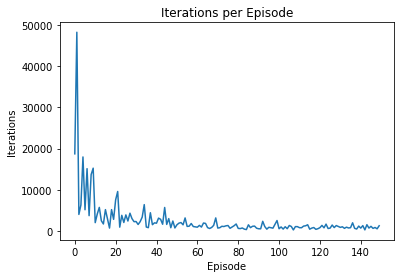

In [ ]:
plt.title('Iterations per Episode')
plt.xlabel('Episode')
plt.ylabel('Iterations')
plt.plot(episode_durations)

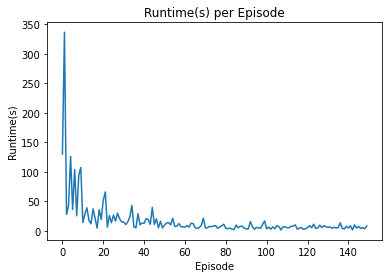

In [ ]:
plt.title('Runtime(s) per Episode')
plt.xlabel('Episode')
plt.ylabel('Runtime(s)')
plt.plot(all_episode_training_time)

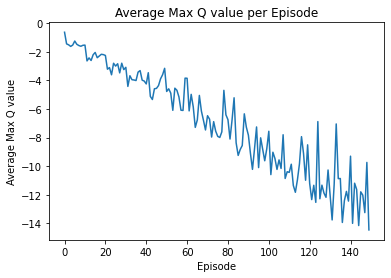

In [ ]:
# calculate average max q value per episode
avg_max_qVals = []
for vals in all_episode_max_q_vals:
    avg_max_qVal = sum(vals)/len(vals)
    avg_max_qVals.append(avg_max_qVal)
plt.title('Average Max Q value per Episode')
plt.xlabel('Episode')
plt.ylabel('Average Max Q value')
plt.plot(avg_max_qVals)

## Record Training

In [ ]:
video_save_interval = 5
def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
      mp4 = mp4list[0]
      video = io.open(mp4, 'r+b').read()
      encoded = base64.b64encode(video)
      ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                  loop controls style="height: 400px;">
                  <source src="data:video/mp4;base64,{0}" type="video/mp4" />
              </video>'''.format(encoded.decode('ascii'))))
    else: 
      print("Could not find video")

def wrap_env(envi):
    envi = Monitor(envi, './video', video_callable=lambda episode_id: episode_id % video_save_interval == 0, force=True)
    return envi

In [ ]:
max_q_vals = []

# Initialize the environment and state
record_env = wrap_env(gym.make('MountainCar-v0').unwrapped)
record_env.reset()

past_ob3_tensor = torch.from_numpy(np.expand_dims(record_env.state, axis=0)).float().to(device)
past_ob2_tensor = torch.from_numpy(np.expand_dims(record_env.state, axis=0)).float().to(device)
past_ob1_tensor = torch.from_numpy(np.expand_dims(record_env.state, axis=0)).float().to(device)
ob_tensor = torch.from_numpy(np.expand_dims(record_env.state, axis=0)).float().to(device)
state = stack_past_four_states(ob_tensor, past_ob1_tensor, past_ob2_tensor, past_ob3_tensor)

start = time.time()
for i in count():
    print("iteration {}".format(i))
    
    record_env.render()
    # Compute Q values from policy net
    q_values = get_q_values(state)
    print("q values: ", q_values)
    max_q_vals.append(q_values.max().item())

    # Choose action based on max q value
    action = select_action(q_values)
    print("action: ", action.item())

    # Observe new state
    new_ob, reward, done, info = record_env.step(action.item())
    new_ob_tensor = torch.from_numpy(np.expand_dims(new_ob, axis=0)).float().to(device)

    if new_ob[0] > 0.1:
      reward = 1
    elif new_ob[0] > 0.25:
      reward = 2
    reward = torch.tensor([reward], device=device)

    # get next state
    past_ob3_tensor = past_ob2_tensor
    past_ob2_tensor = past_ob1_tensor
    past_ob1_tensor = ob_tensor
    ob_tensor = new_ob_tensor

    if not done:
        next_state = stack_past_four_states(ob_tensor, past_ob1_tensor, past_ob2_tensor, past_ob3_tensor)
        print("next state: ", next_state)
    else:
        next_state = None

    # Store the transition in memory
    memory.push(state, action, next_state, reward)

    # Move to the next state
    state = next_state

    # Perform one step of the optimization (on the target network)
    optimize_model()
    if done or i > 100000:
        end = time.time()
        print("Total training runtime in seconds: ", end - start)
        break
# Update the target network, copying all weights and biases in DQN
if i_episode % TARGET_UPDATE == 0:
    target_net.load_state_dict(policy_net.state_dict())

print('Complete')

iteration 0
q values:  tensor([[-15.3814, -15.3753, -15.3560]], grad_fn=<AddmmBackward>)
action:  2
next state:  tensor([[-0.5870,  0.0015, -0.5885,  0.0000, -0.5885,  0.0000, -0.5885,  0.0000]])
iteration 1
q values:  tensor([[-15.4189, -15.4448, -15.4283]], grad_fn=<AddmmBackward>)
action:  0
next state:  tensor([[-0.5860,  0.0010, -0.5870,  0.0015, -0.5885,  0.0000, -0.5885,  0.0000]])
iteration 2
q values:  tensor([[-15.3371, -15.4030, -15.4106]], grad_fn=<AddmmBackward>)
action:  0
next state:  tensor([[-5.8561e-01,  4.2158e-04, -5.8603e-01,  9.5605e-04, -5.8699e-01,
          1.4835e-03, -5.8847e-01,  0.0000e+00]])
iteration 3
q values:  tensor([[-15.3599, -15.3955, -15.4025]], grad_fn=<AddmmBackward>)
action:  0
next state:  tensor([[-5.8573e-01, -1.1601e-04, -5.8561e-01,  4.2158e-04, -5.8603e-01,
          9.5605e-04, -5.8699e-01,  1.4835e-03]])
iteration 4
q values:  tensor([[-15.3972, -15.4073, -15.4287]], grad_fn=<AddmmBackward>)
action:  0
next state:  tensor([[-5.8638e-01,

In [ ]:
record_env.close()
show_video()

In [ ]:
avg_max_qVal = sum(max_q_vals)/len(max_q_vals)
avg_max_qVal

-14.01058282114305

## Test

In [ ]:
video_save_interval = 100
# Initialize the environment and state
test_env = wrap_env(gym.make('MountainCar-v0').unwrapped)
test_env.reset()

past_ob3_tensor = torch.from_numpy(np.expand_dims(test_env.state, axis=0)).float().to(device)
past_ob2_tensor = torch.from_numpy(np.expand_dims(test_env.state, axis=0)).float().to(device)
past_ob1_tensor = torch.from_numpy(np.expand_dims(test_env.state, axis=0)).float().to(device)
ob_tensor = torch.from_numpy(np.expand_dims(test_env.state, axis=0)).float().to(device)
state = stack_past_four_states(ob_tensor, past_ob1_tensor, past_ob2_tensor, past_ob3_tensor)

start = time.time()
for i in count():
    print("iteration {}".format(i))
    
    test_env.render()
    # Compute Q values from policy net
    q_values = get_q_values(state)
    print("q values: ", q_values)
    max_q_vals.append(q_values.max().item())

    # Choose action based on max q value
    action = select_action(q_values)
    print("action: ", action.item())

    # Observe new state
    new_ob, reward, done, info = test_env.step(action.item())
    new_ob_tensor = torch.from_numpy(np.expand_dims(new_ob, axis=0)).float().to(device)

    # get next state
    past_ob3_tensor = past_ob2_tensor
    past_ob2_tensor = past_ob1_tensor
    past_ob1_tensor = ob_tensor
    ob_tensor = new_ob_tensor

    if not done:
        next_state = stack_past_four_states(ob_tensor, past_ob1_tensor, past_ob2_tensor, past_ob3_tensor)
        print("next state: ", next_state)
    else:
        next_state = None

    # Move to the next state
    state = next_state

    if done or i > 50000:
        end = time.time()
        print("Total testing runtime in seconds: ", end - start)
        break

print('Complete')

Streaming output truncated to the last 5000 lines.
q values:  tensor([[-15.4037, -15.3787, -15.3724]], grad_fn=<AddmmBackward>)
action:  2
next state:  tensor([[-0.5672,  0.0078, -0.5750,  0.0064, -0.5814,  0.0050, -0.5863,  0.0035]])
iteration 1897
q values:  tensor([[-15.4110, -15.3860, -15.3793]], grad_fn=<AddmmBackward>)
action:  2
next state:  tensor([[-0.5581,  0.0091, -0.5672,  0.0078, -0.5750,  0.0064, -0.5814,  0.0050]])
iteration 1898
q values:  tensor([[-15.4185, -15.3934, -15.3863]], grad_fn=<AddmmBackward>)
action:  2
next state:  tensor([[-0.5478,  0.0104, -0.5581,  0.0091, -0.5672,  0.0078, -0.5750,  0.0064]])
iteration 1899
q values:  tensor([[-15.4261, -15.4010, -15.3934]], grad_fn=<AddmmBackward>)
action:  0
next state:  tensor([[-0.5382,  0.0095, -0.5478,  0.0104, -0.5581,  0.0091, -0.5672,  0.0078]])
iteration 1900
q values:  tensor([[-15.4486, -15.4235, -15.4146]], grad_fn=<AddmmBackward>)
action:  2
next state:  tensor([[-0.5276,  0.0106, -0.5382,  0.0095, -0.5478

In [ ]:
test_env.close()
show_video()